# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import math

In [2]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [3]:
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [4]:
def auto_canny(image, sigma=0.3):
    v = np.median(image)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

In [5]:
def delete_white_back(image): 
    """ 
    Удалить подпись на белом фоне снизу изображения  
    """
    h, w, _ = image.shape
    if(image[h - 1].mean()  > 253):
        first = True
        for i in range(h // 2, len(image)):
            if(image[i].mean() > 253):
                image = image[0 : i]
                break;
    
    return image

In [6]:
def dots(corners, image):
    """
    Найти крайние точки контура
    """
    h, w, _ = image.shape 
    hm, wm = h // 2, w // 2
    deviation = []
    for i in range(len(corners)): # находим отклонение каждой точки от середины левого угла и правого угла
        now = []
        now.append(abs(0 - corners[i][0][1]) + abs(0 - corners[i][0][0]))
        now.append(abs(0 - corners[i][0][1]) + abs(w - corners[i][0][0]))
        now.append(abs(hm - corners[i][0][1]) + abs(wm - corners[i][0][0]))
        now.append(i)
        deviation.append(now)
    
    left = corners[sorted(deviation, key=lambda dev : dev[0])[0][3]][0]
    right = corners[sorted(deviation, key=lambda dev : dev[1])[0][3]][0]
    middle = corners[sorted(deviation, key=lambda dev : dev[2])[0][3]][0]
    
    return [left, right, middle]
        

In [7]:
def new_dots(left, right, middle):
    """
    Фильтрация угловых точек контура 
    """
    new_left, new_right, new_middle = left.copy(), right.copy(), middle.copy()
    new_left[1], new_right[1] = min(new_left[1], new_right[1]), min(new_left[1], new_right[1])
    new_middle[0] = (new_left[0] + new_right[0]) // 2
    
    return [new_left, new_right, new_middle]

In [8]:
def apply_warpAffine(image, points1, points2):
    image_height, image_width, _ = image.shape

    M = cv2.getAffineTransform(points1, points2)

    new_image_size = int(math.ceil(cv2.norm((image_height, image_width), normType=cv2.NORM_L2)))
    M[0, 2] += (new_image_size - image_width) // 2
    M[1, 2] += (new_image_size - image_height) // 2

    image = cv2.warpAffine(image, M, (new_image_size, new_image_size))

    bordersY = [0, image.shape[0]]
    j = 0;
    if(image[j].mean() > 0):
        j += 1
    
    for i in range(j, len(image) - 1):
        if (np.mean(image[i]) == np.mean(image[0]) and np.mean(image[i + 1]) != np.mean(image[0])
                or np.mean(image[i + 1]) == np.mean(image[0]) and np.mean(image[i]) != np.mean(image[0])):
            bordersY[j] = i + 1
            j += 1 

    bordersX = [0, image.shape[1]]
    j = 0
    if(image[:, j].mean() > 0):
        print(image[:, j].mean())
        j += 1
        
    for i in range(j, len(image[0]) - 1):
        if (np.mean(image[:, i]) == np.mean(image[:, 0]) and np.mean(image[:, i + 1]) != np.mean(image[:, 0])
                or np.mean(image[:, i + 1]) == np.mean(image[:, 0]) and np.mean(image[:, i]) != np.mean(image[:, 0])):
            bordersX[j] = i + 1
            j += 1
            
    image = image[bordersY[0]: bordersY[1], bordersX[0]: bordersX[1]]
    return image

In [9]:
def get_odd_number(x):
    if x % 2 != 0:
        return x
    else:
        return x + 1

In [10]:
def check_is_color(img):
    r_m = np.mean(img[..., 0] / 255)
    g_m = np.mean(img[..., 1] / 255)
    b_m = np.mean(img[..., 2] / 255)
    
    if np.std([r_m, g_m, b_m]) > 4e-2:
        return True
    else:
        return False

In [23]:
def find_color_mask(image, color) -> np.ndarray:
    """
    Create general database which contains statistics about classes of each image.
    Calculate classes colors and thrash empty images.
    :param image: np.ndarray: image
    :param color: tuple: values of class color
    :return: np.ndarray: general data frame of all database
    """
    final_mask = np.ones((image.shape[0], image.shape[1]))

    # create eps location for color
    eps = np.array([10, 10, 10])
    t_color = np.array(color) + eps
    b_color = np.array(color) - eps

    # check each color dim
    for dim, value in enumerate(color):
        def _check_val(x):
            if x > t_color[dim] or x < b_color[dim]:
                return 0.
            return 1.

        check_val = np.vectorize(_check_val)
        final_mask *= check_val(image[:, :, dim])

    # remove black frontier lines from labels map
    final_mask = cv2.dilate(final_mask.astype(np.uint8),
                            np.ones((3, 3), np.uint8),
                            iterations=1).astype(bool)
    return final_mask

In [24]:
def dif_with_back(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = find_color_mask(img_hsv, (110, 140, 140))
#     plot_one_image(mask)
    
    mask = np.repeat(mask[..., np.newaxis], repeats=3, axis=2)
    img = img * (~mask)
    
    return img

Is color: True
2


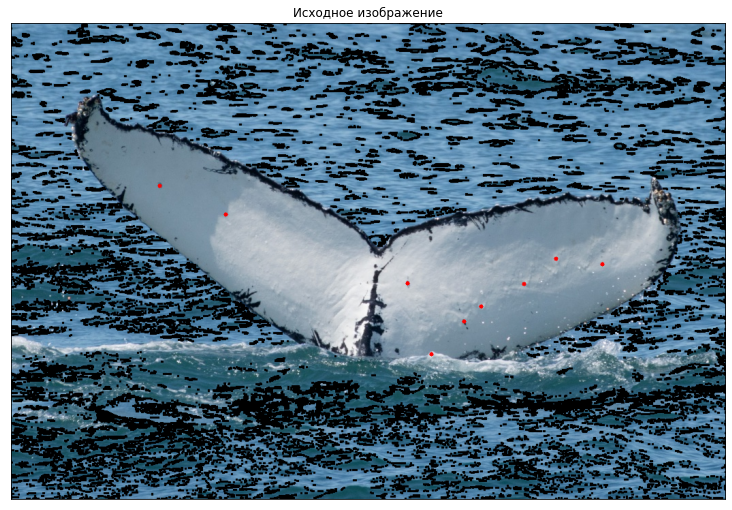

21.699683042789225


IndexError: list assignment index out of range

In [30]:
for i in range(1): 
    
    img = cv2.imread(f'whale_tail/test_image_0{2}.jpg')
    img = gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    is_color = check_is_color(img)
#     plot_one_image(img)
    print(f'Is color: {is_color}')
    
    if is_color:
        img = dif_with_back(img)
    
    img = delete_white_back(img)
    h, w = img.shape[:2]
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    k_h = get_odd_number(h // 10)
    k_w = get_odd_number(w // 12)
    gray_img = cv2.GaussianBlur(gray_img, (k_w, k_h), sigmaX=2, sigmaY=2)
   
    resized = cv2.resize(gray_img, (w // 5, h // 5))
    ret, thresh = cv2.threshold(resized, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = cv2.erode(thresh, np.ones((11, 11)))
    thresh = cv2.dilate(thresh, np.ones((3, 3)))
    resized = cv2.resize(thresh, (w, h))
    
    plus_sq = np.sum(resized) / (w * h) / 255
    minus_sq = 1 - plus_sq
    if plus_sq > minus_sq:
        resized = np.abs(255 - resized)
    
#     plot_one_image(resized)
    
    contours, hierarchy = cv2.findContours(resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    cnts = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 2)
#     plot_one_image(cnts)
    
    corners = cv2.goodFeaturesToTrack(gray_img, maxCorners=100, qualityLevel=0.1, minDistance=30, mask=resized, blockSize=11, \
                                      gradientSize=11, useHarrisDetector=False, k=0.5)
    corners = np.int0(corners)
    
    draw_image = img.copy()
    # Отрисуем найденные точки 
    for i in corners:
        x, y = i.ravel()
        cv2.circle(draw_image, (x, y), 3, 255, -1)
    plot_one_image(draw_image)
    
    old = dots(corners, img)
    new = new_dots(old[0], old[1], old[2])
    img1 = apply_warpAffine(img, np.float32(old), np.float32(new))
    
    plot_transform_result(img, img1)